#Data Science test 

Ce document décrit la première partie de la solution du deuxième problème listé dans les documents "test.pdf", le cahier est divisé en plusieurs parties :

* Problèmes 2 : Extraction d'informations basée sur des données non structurées, dans ce cas, les informations à extraire sont les **valeurs** de TTC. 


# Import des librairies

In [649]:
import pandas as pd
import numpy as np
import spacy
import gensim
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import translate
import multiprocessing
import xgboost as xgb
import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import pickle

# Lecture des données

In [573]:
df = pd.read_csv("train.csv", sep=",")

# Nettoyage de textes

In [571]:
fr_stop_words = [
 'à'
 'au',
 'aux',
 'avec',
 'ce',
 'ces',
 'dans',
 'sous',
 'de',
 'des',
 'du',
 'elle',
 'en',
 'et',
 'eux',
 'il',
 'ils',
 'je',
 'la',
 'le',
 'les',
 'leur',
 'lui',
 'ma',
 'mais',
 'me',
 'même',
 'mes',
 'moi',
 'mon',
 'ne',
 'nos',
 'notre',
 'nous',
 'on',
 'ou',
 'par',
 'pas',
 'pour',
 'qu',
 'que',
 'qui',
 'sa',
 'se',
 'ses',
 'son',
 'sur',
 'ta',
 'te',
 'tes',
 'toi',
 'ton',
 'tu',
 'un',
 'une',
 'vos',
 'votre',
 'vous',
 'été',
 'étée',
 'étées',
 'étés',
 'étant',
 'étante',
 'étants',
 'étantes',
 'suis',
 'es',
 'est',
 'sommes',
 'êtes',
 'sont',
 'serai',
 'seras',
 'sera',
 'serons',
 'serez',
 'seront',
 'serais',
 'serait',
 'serions',
 'seriez',
 'seraient',
 'étais',
 'était',
 'étions',
 'étiez',
 'étaient',
 'fus',
 'fut',
 'fûmes',
 'fûtes',
 'furent',
 'sois',
 'soit',
 'soyons',
 'soyez',
 'soient',
 'fusse',
 'fusses',
 'fût',
 'fussions',
 'fussiez',
 'fussent',
 'ayant',
 'ayante',
 'ayantes',
 'ayants',
 'eu',
 'eue',
 'eues',
 'eus',
 'ai',
 'as',
 'avons',
 'avez',
 'ont',
 'aurai',
 'auras',
 'aura',
 'aurons',
 'aurez',
 'auront',
 'aurais',
 'aurait',
 'aurions',
 'auriez',
 'auraient',
 'avais',
 'avait',
 'avions',
 'aviez',
 'avaient',
 'eut',
 'eûmes',
 'eûtes',
 'eurent',
 'aie',
 'aies',
 'ait',
 'ayons',
 'ayez',
 'aient',
 'eusse',
 'eusses',
 'eût',
 'eussions',
 'eussiez',
 'eussent'
]

In [572]:
letters = 'abcdefghijklmnopqrstuvwxyz'

## convertir les labels en valeurs numériques

In [574]:
df["label"] = df["label"].apply(lambda x: x.replace(",", "."))
df["label"] = df["label"].astype(float)
df["label"] = df["label"].apply(lambda x: round(x,1))

## convertir les textes en minuscules

In [575]:
df = df[df['sentence'].notnull()]
df['sentence'] = df['sentence'].astype(str)
df["sentence"] = df["sentence"].str.lower()

## Eliminer les espaces les "0.00" des cotés des textes

In [576]:
df["sentence"] = df["sentence"].apply(lambda x: x.rstrip())
df["sentence"] = df["sentence"].apply(lambda x: x.lstrip())
df["sentence"] = df["sentence"].apply(lambda x: x.lstrip("0.00"))

## Supprimer les "." des abréviations

In [577]:
df['sentence'] = df['sentence'].str.replace("h.t", 'ht')
df['sentence'] = df['sentence'].str.replace("t.t.c", 'ttc')
df['sentence'] = df['sentence'].str.replace("t.v.a", 'tva')

<ipython-input-577-a42371fb443e>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sentence'] = df['sentence'].str.replace("h.t", 'ht')
<ipython-input-577-a42371fb443e>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sentence'] = df['sentence'].str.replace("t.t.c", 'ttc')
<ipython-input-577-a42371fb443e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sentence'] = df['sentence'].str.replace("t.v.a", 'tva')


## Remplacer les "," par "."

In [578]:
df["sentence"] = df["sentence"].apply(lambda x: x.replace("," ,"."))

## Reformuler certains mots

In [579]:
df['sentence'] = df['sentence'].str.replace(r"\b" + "va" + r"\b", 'tva')
df['sentence'] = df['sentence'].str.replace(r"\b" + "cotal" + r"\b", 'total')
df['sentence'] = df['sentence'].str.replace(r"\b" + "soustotal" + r"\b", 'sous total')

<ipython-input-579-34cd51738a98>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sentence'] = df['sentence'].str.replace(r"\b" + "va" + r"\b", 'tva')
<ipython-input-579-34cd51738a98>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sentence'] = df['sentence'].str.replace(r"\b" + "cotal" + r"\b", 'total')
<ipython-input-579-34cd51738a98>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['sentence'] = df['sentence'].str.replace(r"\b" + "soustotal" + r"\b", 'sous total')


In [580]:
fr_accent = list("éèàêç")

In [581]:
df['sentence'] = df['sentence'].str.replace("é", 'e')
df['sentence'] = df['sentence'].str.replace("è", 'e')
df['sentence'] = df['sentence'].str.replace("ê", 'e')
#df['sentence'] = df['sentence'].str.replace("à", 'a')
df['sentence'] = df['sentence'].str.replace("ç", 'c')

## Eliminer les stops words et ponctuations

In [1]:
for stop_word in fr_stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    df['sentence'] = df['sentence'].str.replace(regex_stopword, ' ')
    df['sentence'] = df['sentence'].apply(lambda x: x.split())
    df['sentence'] = df['sentence'].apply(lambda x: ' '.join([word for word in x]))

NameError: name 'fr_stop_words' is not defined

In [583]:
punctuation_signs = list("#{}()[|=+]:,;^~'_-%`@$¤£^¨*µù%!§/")

In [584]:
for punct_sign in punctuation_signs:
    df['sentence'] = df['sentence'].str.replace(punct_sign, ' ')

<ipython-input-584-8013ab368956>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  df['sentence'] = df['sentence'].str.replace(punct_sign, ' ')


## Eliminer les expressions de devises

In [585]:
df["sentence"] = df["sentence"].apply(lambda x: x.replace("sad", ""))
df["sentence"] = df["sentence"].apply(lambda x: x.replace("dhs", ""))
df["sentence"] = df["sentence"].apply(lambda x: x.replace("hs", ""))
df["sentence"] = df["sentence"].apply(lambda x: x.replace("dh", ""))
df["sentence"] = df["sentence"].apply(lambda x: x.replace("mad", ""))
df["sentence"] = df["sentence"].apply(lambda x: x.replace("dirhams", ""))
df["sentence"] = df["sentence"].apply(lambda x: x.replace("dirhams", ""))

## Supprimer certains mots indésirables

In [586]:
unwanted_words = ['sainter', 'chaquinter', 'esarl', 'inter', 'osall', 'sain', 'or', 'var', 'vices', 'assistance', 'oocentimes', 'stier'] 

In [587]:
for word in unwanted_words:
    df["sentence"] = df["sentence"].apply(lambda x: x.split())
    df["sentence"] = df["sentence"].apply(lambda x: [e for e in x if e not in unwanted_words])
    df["sentence"] = df["sentence"].apply(lambda x: [e for e in x if len(e)>=2])
    df["sentence"] = df["sentence"].apply(lambda x: [e for e in x if not e.startswith(".")])
    df["sentence"] = df["sentence"].apply(lambda x: " ".join(x))

## Détecter les nombres à partir des phrases

In [588]:
df["numerical_values"] = df["sentence"].apply(lambda x: x.split())
df["numerical_values"] = df["numerical_values"].apply(lambda x: [e for e in x if any(char for char in e if char.isdigit())])
df["numerical_values"] = df["numerical_values"].apply(lambda x: [e.translate({ord(i): None for i in letters}) for e in x])
df["numerical_values"] = df["numerical_values"].apply(lambda x: [float(e) for e in x])
df["numerical_values"] = df["numerical_values"].apply(lambda x: [e for e in x if e!=0])
df["numerical_values"] = df["numerical_values"].apply(lambda x: [round(e,1) for e in x])

In [589]:
df["len_numerical_values"] = df["numerical_values"].apply(lambda x: len(x))

<AxesSubplot:ylabel='len_numerical_values'>

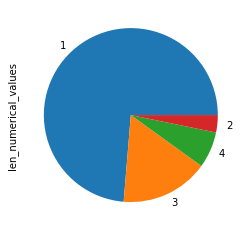

In [590]:
df["len_numerical_values"].value_counts().plot.pie()

## Recevoir l'indice du label dans la liste des nombres

In [591]:
indices = []
for ligne in df[["numerical_values", "label"]].itertuples():
    try:
        indices.append(ligne[1].index(ligne[2]))
    except:
        print(ligne)

In [592]:
df["label_index"] = indices

In [563]:
df.to_excel("df.xlsx", index=None)

# Feature Engineering

<p>Dans ce type de problème, Doc2Vec est la bonne solution pour gérer la similarité entre les textes.</p>

In [598]:
train_tagged = df.apply(lambda r: TaggedDocument(words=word_tokenize(r['sentence']), tags=[r.indice]), axis=1)

In [599]:
vector_size=400
%time model = Doc2Vec(vector_size=vector_size, epochs=400, dm=0, workers= multiprocessing.cpu_count())

Wall time: 999 µs


In [600]:
train_tagged

0                                   ([ttc, 640.00], [0])
1                          ([total, payee, 640.00], [1])
2                                 ([total, 130.00], [2])
3      ([total, 108.33, tva, 21.67, total, 130.00], [3])
4                   ([total, facture, ttc, 350.00], [4])
                             ...                        
337                             ([total, 766.00], [337])
338    ([total, 766.00, presente, facture, arreteeàla...
339                            ([total, 1793.00], [339])
340                            ([total, 1793.00], [340])
341                 ([total, payee, 350.001, au], [341])
Length: 342, dtype: object

In [601]:
model.build_vocab(train_tagged, progress_per=500)

In [602]:
%time model.train(train_tagged, total_examples=model.corpus_count, epochs=model.epochs)

Wall time: 4.04 s


In [603]:
model.save("doc2vecRound1.model")

In [604]:
df["vectors"] = df.apply(lambda x: model.infer_vector(word_tokenize(x['sentence'].replace(';', ''))), axis=1)

In [606]:
def generateColNames():
    arr = []
    for i in range(vector_size):
        arr.append("keyword" + str(i+1))
    return arr

In [607]:
newCols = generateColNames()

In [609]:
df[newCols] = pd.DataFrame(df.vectors.values.tolist(), index=df.index)

# Construction du Modèle

In [617]:
keyword1Start = 7
dataframeX = pd.concat([df.iloc[:,keyword1Start:vector_size+keyword1Start], df["len_numerical_values"]], axis=1)
dataframeY = df[['label_index']]

In [618]:
dataframeX

,keyword1,keyword2,keyword3,keyword4,keyword5,keyword6,keyword7,keyword8,keyword9,keyword10,...,keyword392,keyword393,keyword394,keyword395,keyword396,keyword397,keyword398,keyword399,keyword400,len_numerical_values
0,-0.012178,-0.016566,0.070371,0.025749,-0.127844,-0.037545,0.016650,-0.028058,0.049474,-0.009747,...,0.131830,-0.009035,0.097121,-0.042735,0.069323,0.028137,0.022252,-0.029944,-0.017005,1
1,-0.127614,-0.062268,-0.108852,-0.028547,-0.130495,0.083932,0.096340,0.120887,0.055749,0.154820,...,0.199665,-0.152702,0.035686,0.073426,-0.076873,0.033804,-0.037433,-0.012025,0.234372,1
2,0.068150,-0.021559,0.034124,0.057887,-0.116551,0.008654,0.135784,-0.073897,0.046805,0.040170,...,0.073665,-0.053448,-0.019835,0.034985,0.066460,-0.068105,-0.025021,-0.016434,0.099741,1
3,0.039365,-0.046083,0.078141,0.156630,-0.187239,0.006378,0.216570,-0.175401,0.053433,-0.003577,...,0.075779,-0.079899,0.064679,0.065368,0.002453,-0.116253,-0.047489,0.010544,0.151737,3
4,0.029468,-0.103314,-0.026429,0.041979,-0.106992,0.010816,-0.024951,0.044401,0.054669,-0.019388,...,0.071595,-0.005007,0.126821,-0.014555,-0.023144,0.075396,0.027719,-0.033610,0.053723,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,0.006672,-0.048118,-0.018325,-0.011271,-0.063012,0.018679,0.016459,-0.012571,0.035777,0.025477,...,0.068834,0.000228,0.049831,-0.011149,0.001262,0.047560,0.004263,-0.009345,0.050632,1
338,-0.107939,-0.016066,-0.017981,-0.053964,-0.180667,0.077547,0.083659,0.084128,0.193576,0.270135,...,0.032975,-0.015365,-0.035978,-0.013376,-0.073866,0.243604,-0.002532,-0.092293,0.071059,1
339,-0.000900,-0.048699,-0.033356,-0.014273,-0.054047,0.022247,0.018603,-0.005363,0.046693,0.037112,...,0.059097,0.006140,0.043665,-0.014065,-0.006289,0.051542,0.007814,-0.006947,0.056965,1
340,-0.008200,-0.066950,-0.037551,-0.021936,-0.068845,0.028569,0.027067,-0.011528,0.049866,0.040304,...,0.075886,0.003865,0.052152,-0.021925,-0.003019,0.049743,0.001419,-0.004308,0.065485,1


In [623]:
j = 0
trainX, testX, trainY, testY = train_test_split(dataframeX, dataframeY, test_size=0.20, random_state=j, stratify=dataframeY)

In [624]:
model = xgb.XGBClassifier()

In [625]:
model.fit(trainX, trainY)

C:\Users\othmane_fathallah\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\othmane_fathallah\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[03:16:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [628]:
y_pred = model.predict(testX)
predictions = [round(value) for value in y_pred]

In [634]:
predDF = pd.DataFrame()
predDF["predictions"] = predictions

In [630]:
accuracy = accuracy_score(testY, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 98.55%


In [641]:
testResults = pd.concat([df.iloc[testX.index].reset_index(drop=True), predDF], axis=1)

In [642]:
isEqual = np.where(testResults["label_index"]==testResults["predictions"], True, False)
testResults["isEqual"] = isEqual

In [646]:
testResults = testResults[['indice', 'sentence', 'label', 'numerical_values',
       'len_numerical_values', 'label_index', 'predictions', 'isEqual']]

In [647]:
testResults.columns

Index(['indice', 'sentence', 'label', 'numerical_values',
       'len_numerical_values', 'label_index', 'predictions', 'isEqual'],
      dtype='object')

In [648]:
testResults.to_excel("testResults.xlsx", index=None)

In [651]:
pickle.dump(model, open("XGBoost Model.pkl", "wb"))